In [107]:
import pandas

In [285]:
def get_signal(subject_id, run, mask):
    subject_id = '%02d' % int(subject_id)
    run = '%02d' % int(run)    
    run0 = int(run) - 1
    
    signal = np.loadtxt('/home/gdholla1/projects/bias/data/derivatives/extracted_signal/highpassed_motion/_mask_{mask}_subject_id_{subject_id}/_extracter_highpassed_motion{run0}/sub-{subject_id}_task-randomdotmotion_run-{run}_bold_unwarped_st_dtype_mcf_mask_gms_tempfilt_regfilt_maths_ts.txt'.format(**locals()))
    
    signal = (signal / signal.mean()) * 100
    signal -= signal.mean()
    
    return signal

def get_onsets(subject_id, run, design='model0', shift=0):

    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior.pandas')
    df = df[(df.subj_idx == subject_id) & (df.block == run)]

    df['onset_cue'] += shift
    df['onset_stim'] += shift
    
    
    if design == 'model0':
        onsets_cue = df.onset_cue.tolist()
        onsets_stim = df.onset_stim.tolist()

        conditions=['onsets_cue',
                    'onsets_stim',]
        
        onsets=[onsets_cue,
                onsets_stim]
        
    elif design == 'model1a':
        conditions=['payoff_cue',
                    'neutral_cue',
                    'difficult_rdm',
                    'easy_rdm']
        
        onsets=[df[df.cue != 'neutral'].onset_cue.tolist(),
                df[df.cue == 'neutral'].onset_cue.tolist(),
                df[df.difficulty == 'easy'].onset_stim.tolist(),
                df[df.difficulty == 'hard'].onset_stim.tolist()]
        
    elif design == 'model1b':
        conditions= ['left', 'right', 'neutral', 'easy', 'hard']
        
        onsets=[df[df.cue == 'left'].onset_cue.tolist(),
                df[df.cue == 'right'].onset_cue.tolist(),                
                df[df.cue == 'neutral'].onset_cue.tolist(),
                df[df.difficulty == 'easy'].onset_stim.tolist(),
                df[df.difficulty == 'hard'].onset_stim.tolist()]        
        
        
    elif design == 'model1c':
        conditions=['payoff_cue',
                    'neutral_cue',
                    'easy rdm (correct)',
                    'hard rdm (correct)',
                    'easy rdm (error)',
                    'hard rdm (error)']
        
        onsets=[df[df.cue != 'neutral'].onset_cue.tolist(),
                df[df.cue == 'neutral'].onset_cue.tolist(),
                df[(df.difficulty == 'easy') & (df.correct == 1)].onset_stim.tolist(),
                df[(df.difficulty == 'hard') & (df.correct == 1)].onset_stim.tolist(),
                df[(df.difficulty == 'easy') & (df.correct == 0)].onset_stim.tolist(),
                df[(df.difficulty == 'hard') & (df.correct == 0)].onset_stim.tolist()]        
        
    elif design == 'model3':
        conditions=['payoff_cue',
                    'neutral_cue',
                    'left response',
                    'right response']
        
        onsets=[df[df.cue != 'neutral'].onset_cue.tolist(),
                df[df.cue == 'neutral'].onset_cue.tolist(),
                df[df.response == 1].onset_stim.tolist(),
                df[df.response == 2].onset_stim.tolist()]        
        
        
    elif design == 'model4':
        
        onsets_neutral_cue_correct = df[(df.cue_validity == 'neutral') & (df.correct == 1)].onset_stim.tolist()
        onsets_neutral_cue_error = df[(df.cue_validity == 'neutral') & (df.correct == 0)].onset_stim.tolist()
        
        onsets_valid_cue_correct = df[(df.cue_validity == 'valid') & (df.correct == 1)].onset_stim.tolist()
        onsets_valid_cue_error = df[(df.cue_validity == 'valid') & (df.correct == 0)].onset_stim.tolist()        
        
        onsets_invalid_cue_correct = df[(df.cue_validity == 'invalid') & (df.correct == 1)].onset_stim.tolist()
        onsets_invalid_cue_error = df[(df.cue_validity == 'invalid') & (df.correct == 0)].onset_stim.tolist()                

        
        conditions=['payoff_cue',
                    'neutral_cue',
                    'valid (correct)',
                    'valid (error)',
                    'neutral (correct)',
                    'neutral (error)',
                    'invalid (correct)',
                    'invalid (error)']
        
        onsets=[df[df.cue != 'neutral'].onset_cue.tolist(),
                df[df.cue == 'neutral'].onset_cue.tolist(),
                onsets_valid_cue_correct,
                onsets_valid_cue_error,
                onsets_neutral_cue_correct,
                onsets_neutral_cue_error,
                onsets_invalid_cue_correct,
                onsets_invalid_cue_error]                
    
    return dict(zip(conditions, onsets))

In [286]:
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [287]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'model1a', shift=-1.5)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))
            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical with Derivative'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R_C/all the input arrays must have same number of dimensions


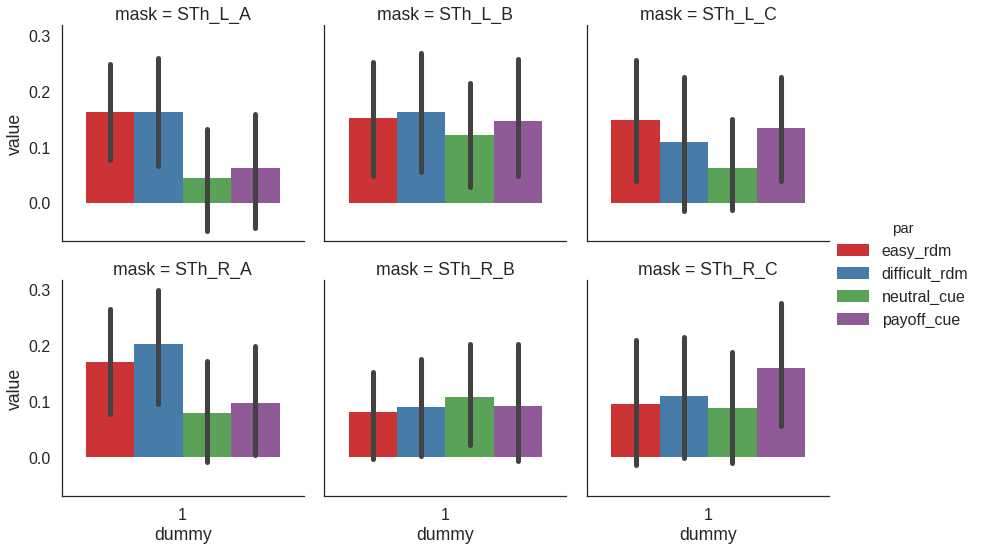

In [288]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm['% signal change'] = df_glm['value']
sns.set_palette('Set1')
sns.set_context('poster')
sns.set_style('white')

# sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95, hue_order=['payoff_cue (left)', 'payoff_cue (right)', 'neutral_cue','difficult_rdm', 'easy_rdm'])
sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95)

In [242]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])

In [243]:

tmp = tmp['payoff_cue'] - tmp['neutral_cue']
shifts = shifts.merge(tmp, left_index=True, right_index=True)


In [244]:
masks = ['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']

{'color': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), 'marker': 'o'}
{'color': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), 'marker': 'o'}
{'color': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), 'marker': 'o'}
{'color': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), 'marker': 'o'}
{'color': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), 'marker': 'o'}
{'color': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), 'marker': 'o'}


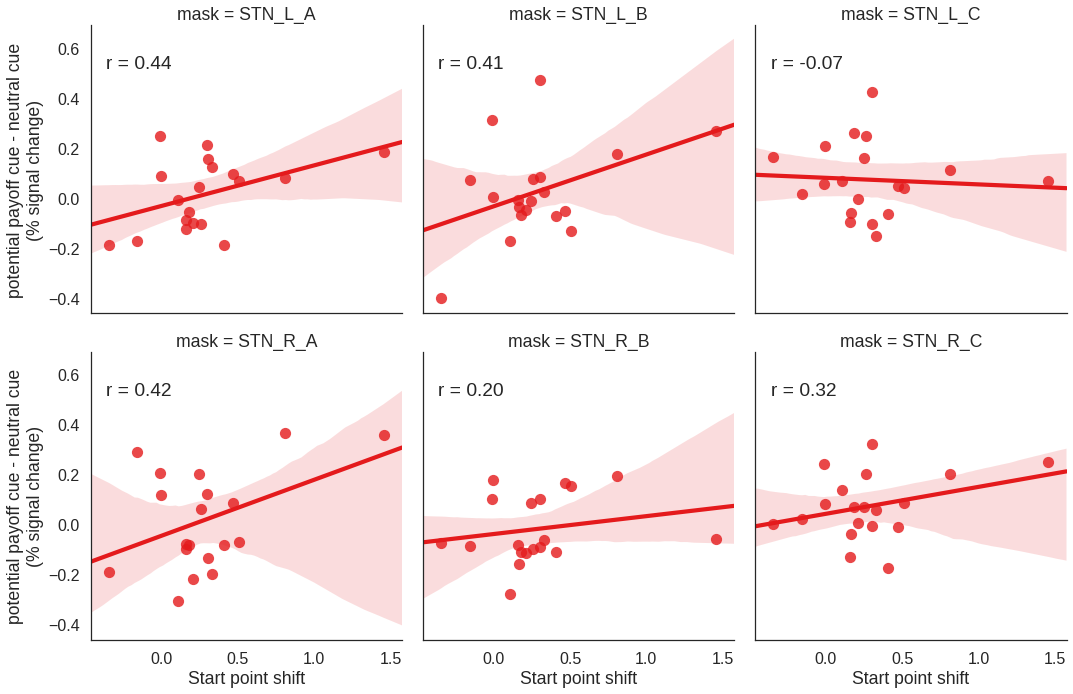

In [245]:
tmp = pandas.melt(shifts, id_vars=['v_cue_coding', 'v_difficulty', 'z_cue_coding'], var_name='mask')

tmp['mask'] = tmp['mask'].apply(lambda x: x.replace('STh', 'STN'))

# fac = sns.FacetGrid(tmp, col='mask', col_wrap=3)

# # def lmplot(x, y, color, **kwargs):
# #     sns.lmplot(x, y, **kwargs)

def make_r_title(x, y, **kwargs):
    print kwargs
    r, p = sp.stats.pearsonr(x, y)
    
    title = plt.gca().get_title()
    
    ax = plt.gca()

    y = 0.85 - len(ax.texts) * 0.05
    ax.annotate('r = %.2f' % (r), xy=(0.05,y), xycoords='axes fraction')


fac = sns.lmplot('z_cue_coding', 'value', data=tmp, col='mask', col_wrap=3)
fac.map(make_r_title, 'z_cue_coding', 'value', )
# fac.set_titles('{col_name}')
fac.set_xlabels('Start point shift')
fac.set_ylabels('potential payoff cue - neutral cue\n(% signal change)')

plt.savefig('/home/gdholla1/projects/bias/reports/figures/startpoint_bold_interindividual.pdf')

In [246]:
import statsmodels

In [247]:
results = []

for mask in masks:
    
    shifts[mask] = (shifts[mask] - shifts[mask].mean()) / shifts[mask].std()
    
#     sns.lmplot('z_cue_coding', mask, shifts, robust=True)
    
    r, p = sp.stats.pearsonr(shifts['z_cue_coding'], shifts[mask])
#     r_, p_ = sp.stats.spearmanr(shifts['z_cue_coding'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p, })
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

,mask,p,r,p.fdr
0,STh_L_A,0.059802,0.439386,0.157334
1,STh_L_B,0.078667,0.413219,0.157334
2,STh_L_C,0.780019,-0.068660,0.780019
3,STh_R_A,0.071860,0.422059,0.157334
4,STh_R_B,0.408191,0.201466,0.489829
5,STh_R_C,0.185226,0.317558,0.277839


In [248]:
shifts['STh_R_B'] = np.round(shifts['STh_R_B'], 3)

In [261]:
%%R -i shifts -o chains_left -o chains_right
library(BayesFactor)

bf = regressionBF(z_cue_coding ~ 1 + STh_L_A + STh_L_B + STh_L_C, data = shifts, whichModels='all')
print(bf)
chains_left = posterior(bf[7], iterations=100000)
print(summary(chains_left))


bf = regressionBF(z_cue_coding ~ 1 + STh_R_A + STh_R_B + STh_R_C, data =shifts)
print(bf)
chains_right = posterior(bf[7], iterations=100000)

# bf = lmBF(z_cue_coding ~ 1 + STh_R_B, data =shifts, iterations=10000000)
# print(bf)
# chains_right = posterior(bf[4], iterations=10000)

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L_A                     : 1.525849  ±0%
[2] STh_L_B                     : 1.282818  ±0%
[3] STh_L_C                     : 0.4158916 ±0%
[4] STh_L_A + STh_L_B           : 0.8563188 ±0%
[5] STh_L_A + STh_L_C           : 0.8177114 ±0%
[6] STh_L_B + STh_L_C           : 0.7701932 ±0%
[7] STh_L_A + STh_L_B + STh_L_C : 0.5735563 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS


Iterations = 1:1e+05
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

            Mean      SD  Naive SE Time-series SE
STh_L_A  0.07038 0.09169 0.0002899      0.0003029
STh_L_B  0.06485 0.09322 0.0002948      0.0003122
STh_L_C -0.04477 0.07046 0.0002228      0.0002333
sig2     0.12806 0.04695 0.0001485      0.0001754
g        0.17860 0

In [262]:
chains_left.shape

(100000, 5)

0.84845000000000004

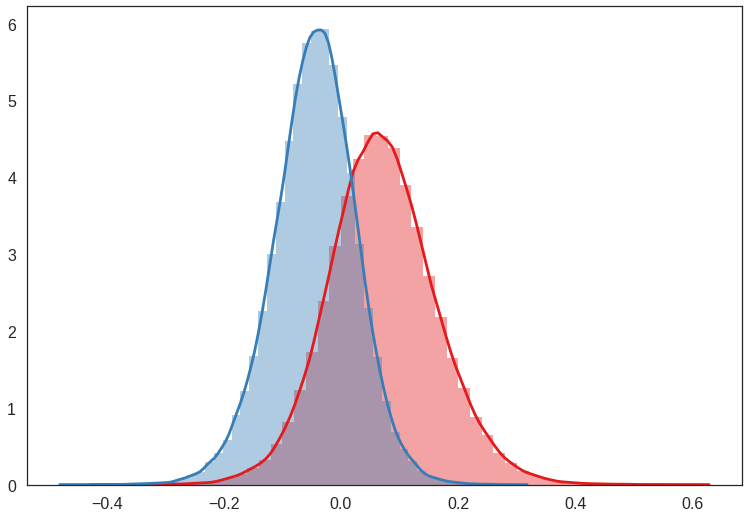

In [264]:
sns.distplot(chains_left[: ,0])
sns.distplot(chains_left[: ,2])

((chains_left[: ,0] - chains_left[: ,2]) > 0).mean()

0.66459000000000001

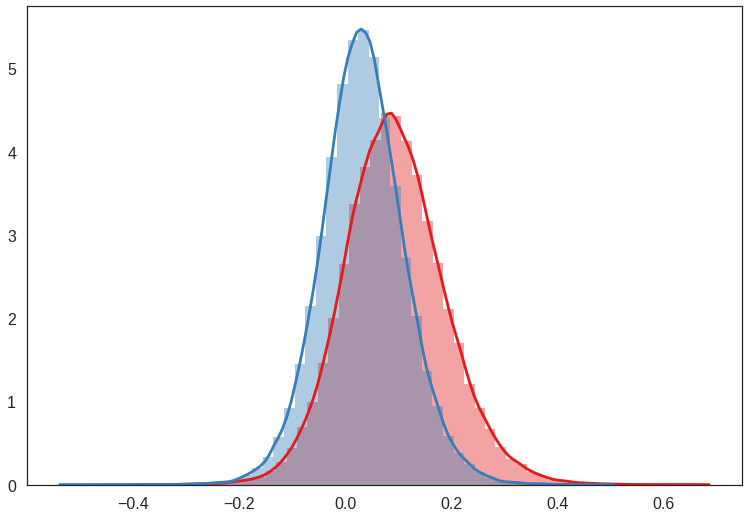

In [266]:
sns.distplot(chains_right[: ,0])
sns.distplot(chains_right[: ,2])

((chains_right[: ,0] - chains_right[: ,2]) > 0).mean()

# Model 1b



In [233]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'model1b', shift=-3)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))
            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R_C/all the input arrays must have same number of dimensions


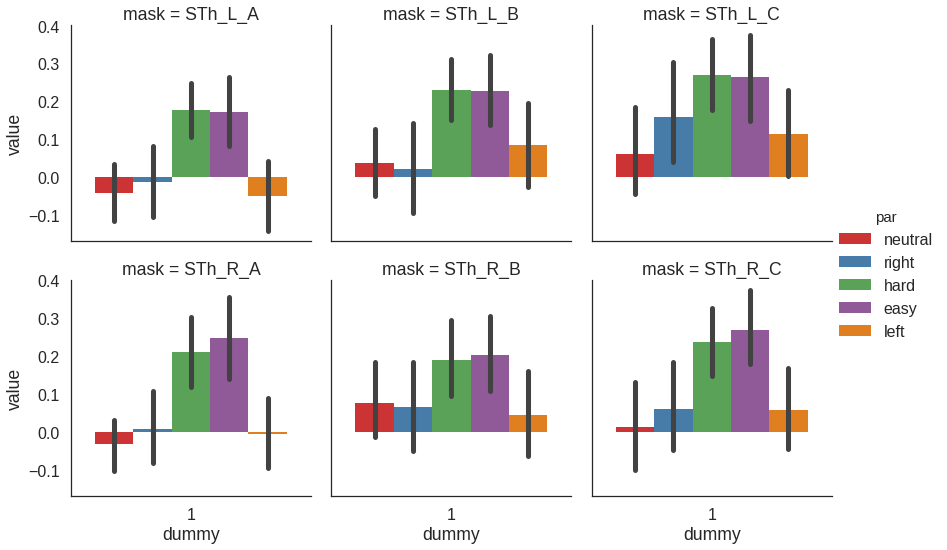

In [234]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm['% signal change'] = df_glm['value']
sns.set_palette('Set1')
sns.set_context('poster')
sns.set_style('white')

# sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95, hue_order=['payoff_cue (left)', 'payoff_cue (right)', 'neutral_cue','difficult_rdm', 'easy_rdm'])
sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95)

In [235]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])
tmp = tmp['left'] - tmp['neutral']
shifts = shifts.merge(tmp, left_index=True, right_index=True)


,mask,p,r,p.fdr
0,STh_L_A,0.159133,0.336348,0.318266
1,STh_L_B,0.045114,0.464495,0.135342
2,STh_L_C,0.459875,0.180399,0.607287
3,STh_R_A,0.009144,0.580629,0.054863
4,STh_R_B,0.623944,0.120228,0.623944
5,STh_R_C,0.506073,0.162570,0.607287


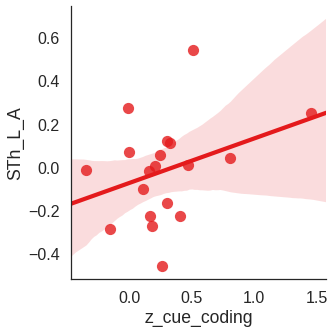

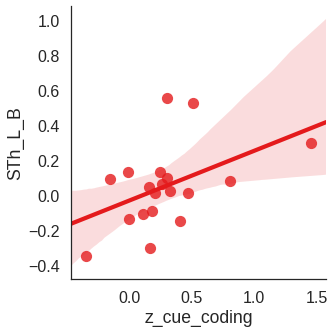

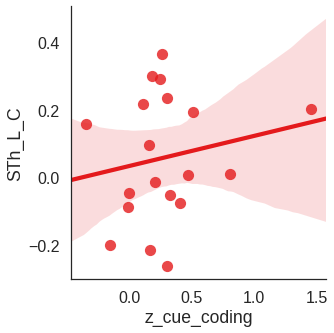

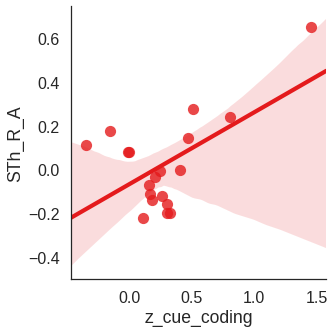

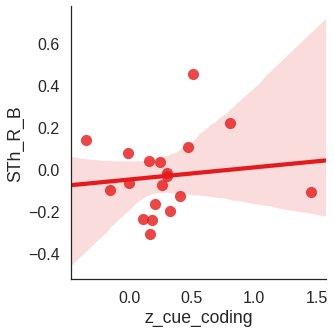

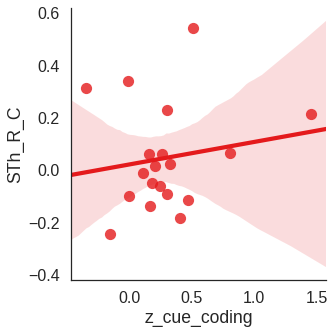

In [236]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])
tmp = tmp['left'] - tmp['neutral']
shifts = shifts.merge(tmp, left_index=True, right_index=True)

results = []

for mask in masks:
    sns.lmplot('z_cue_coding', mask, shifts)
    
    r, p = sp.stats.pearsonr(shifts['z_cue_coding'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p})
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

In [237]:
%%R -i shifts
library(BayesFactor)

bf = regressionBF(z_cue_coding ~ 1 + STh_L_A + STh_L_B + STh_L_C, data = shifts, whichModels='all')
print(bf)

bf = regressionBF(z_cue_coding ~ 1 + STh_R_A + STh_R_B + STh_R_C, data = shifts, whichModels='all')
print(bf)

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L_A                     : 0.8415289 ±0%
[2] STh_L_B                     : 1.832123  ±0%
[3] STh_L_C                     : 0.4935027 ±0%
[4] STh_L_A + STh_L_B           : 0.9854889 ±0%
[5] STh_L_A + STh_L_C           : 0.5547191 ±0%
[6] STh_L_B + STh_L_C           : 0.8492104 ±0%
[7] STh_L_A + STh_L_B + STh_L_C : 0.5522766 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_R_A                     : 5.543004  ±0%
[2] STh_R_B                     : 0.4412454 ±0%
[3] STh_R_C                     : 0.4750373 ±0%
[4] STh_R_A + STh_R_B           : 2.808703  ±0%
[5] STh_R_A + STh_R_C           : 2.230734  ±0%
[6] STh_R_B + STh_R_C           : 0.2537567 ±0%
[7] STh_R_A + STh_R_B + STh_R_C : 1.395749  ±0%

Against de

,mask,p,r,p.fdr
0,STh_L_A,0.231653,0.288100,0.694958
1,STh_L_B,0.855156,0.044906,0.885029
2,STh_L_C,0.846406,0.047649,0.885029
3,STh_R_A,0.007574,0.592028,0.045444
4,STh_R_B,0.422739,-0.195400,0.845478
5,STh_R_C,0.885029,-0.035578,0.885029


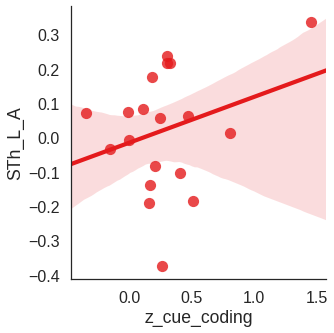

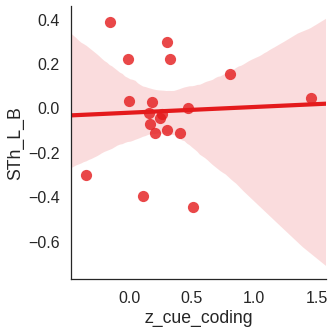

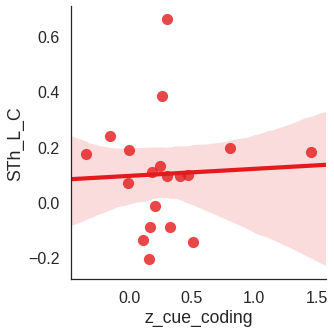

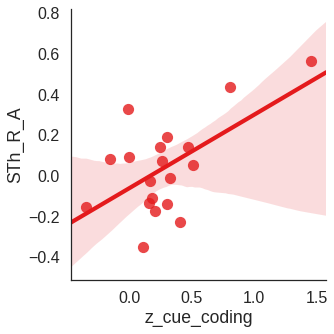

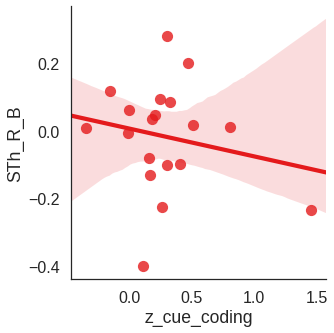

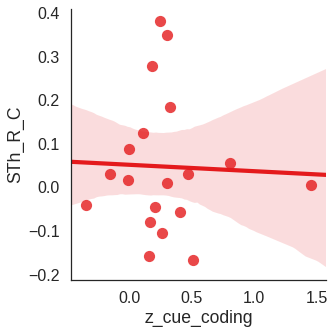

In [238]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])
tmp = tmp['right'] - tmp['neutral']
shifts = shifts.merge(tmp, left_index=True, right_index=True)

results = []

for mask in masks:
    sns.lmplot('z_cue_coding', mask, shifts)
    
    r, p = sp.stats.pearsonr(shifts['z_cue_coding'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p})
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

In [239]:
%%R -i shifts
library(BayesFactor)

bf = regressionBF(z_cue_coding ~ 1 + STh_L_A + STh_L_B + STh_L_C, data = shifts, whichModels='all')
print(bf)

bf = regressionBF(z_cue_coding ~ 1 + STh_R_A + STh_R_B + STh_R_C, data = shifts, whichModels='all')
print(bf)

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L_A                     : 0.6844455 ±0%
[2] STh_L_B                     : 0.4091851 ±0%
[3] STh_L_C                     : 0.4098106 ±0%
[4] STh_L_A + STh_L_B           : 0.3526497 ±0%
[5] STh_L_A + STh_L_C           : 0.3499384 ±0%
[6] STh_L_B + STh_L_C           : 0.2225549 ±0%
[7] STh_L_A + STh_L_B + STh_L_C : 0.2078282 ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_R_A                     : 6.359203  ±0%
[2] STh_R_B                     : 0.5113045 ±0%
[3] STh_R_C                     : 0.4073421 ±0%
[4] STh_R_A + STh_R_B           : 8.512376  ±0%
[5] STh_R_A + STh_R_C           : 2.824732  ±0%
[6] STh_R_B + STh_R_C           : 0.2738131 ±0%
[7] STh_R_A + STh_R_B + STh_R_C : 3.600074  ±0.01%

Against

# Difficulty

# Include errors

In [289]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'model1a', shift=-3)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))
            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical with Derivative'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R_C/all the input arrays must have same number of dimensions


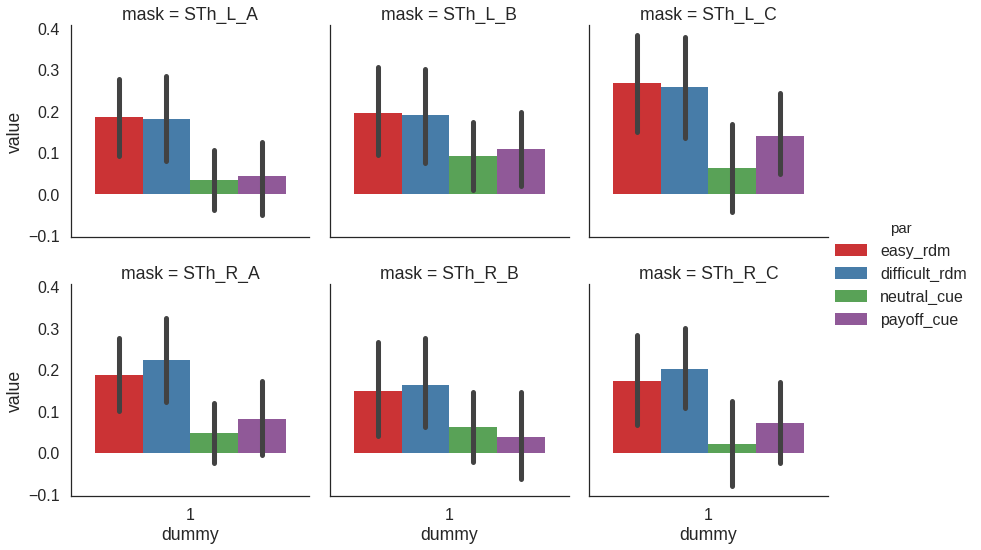

In [290]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm['% signal change'] = df_glm['value']
sns.set_palette('Set1')
sns.set_context('poster')
sns.set_style('white')

# sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95, hue_order=['payoff_cue (left)', 'payoff_cue (right)', 'neutral_cue','difficult_rdm', 'easy_rdm'])
sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95)

df_glm_include_errors = df_glm.copy()
df_glm_include_errors['include errors'] = True

In [291]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])

tmp = tmp['difficult_rdm'] - tmp['easy_rdm']
shifts = shifts.merge(tmp, left_index=True, right_index=True)

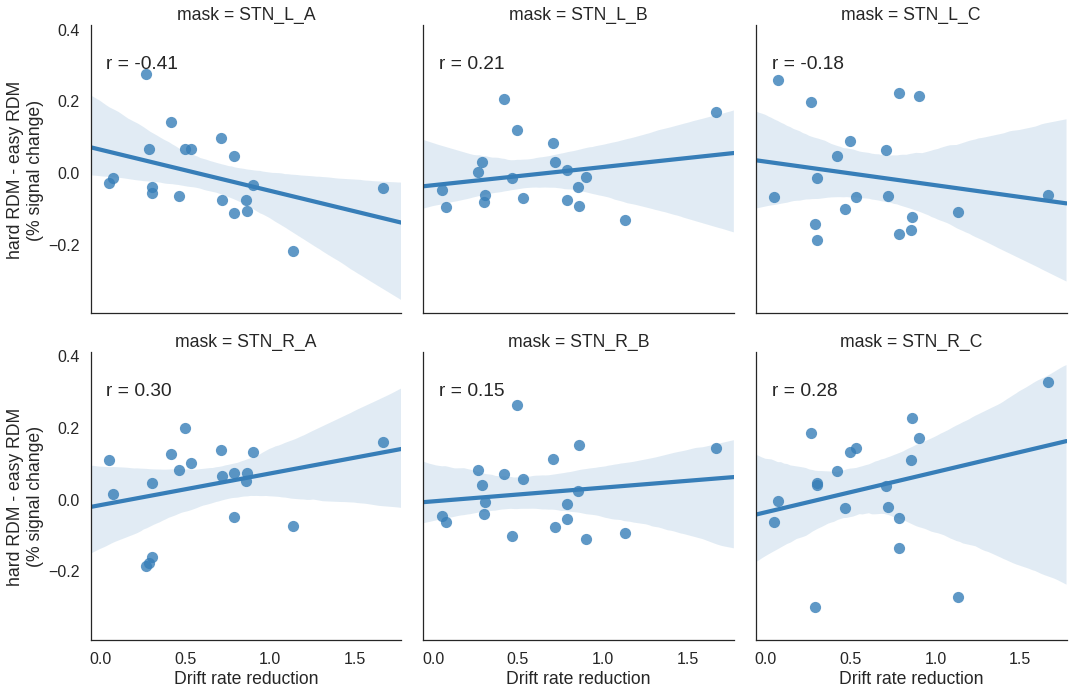

In [292]:
tmp = pandas.melt(shifts, id_vars=['v_cue_coding', 'v_difficulty', 'z_cue_coding'], var_name='mask')

tmp['mask'] = tmp['mask'].apply(lambda x: x.replace('STh', 'STN'))

# fac = sns.FacetGrid(tmp, col='mask', col_wrap=3)

# # def lmplot(x, y, color, **kwargs):
# #     sns.lmplot(x, y, **kwargs)

def make_r_title(x, y, **kwargs):
    r, p = sp.stats.pearsonr(x, y)
    
    title = plt.gca().get_title()
    
    ax = plt.gca()

    y = 0.85 - len(ax.texts) * 0.05
    ax.annotate('r = %.2f' % (r), xy=(0.05,y), xycoords='axes fraction')


sns.set_palette(sns.color_palette('Set1')[1:])

tmp['v_difficulty'] *= -1

fac = sns.lmplot('v_difficulty', 'value', data=tmp, col='mask', col_wrap=3)
fac.map(make_r_title, 'v_difficulty', 'value', )
# fac.set_titles('{col_name}')
fac.set_xlabels('Drift rate reduction')
fac.set_ylabels('hard RDM - easy RDM\n(% signal change)')


In [293]:
results = []

for mask in masks:
    r, p = sp.stats.pearsonr(shifts['v_difficulty'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p})
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

,mask,p,r,p.fdr
0,STh_L_A,0.081325,0.409921,0.487947
1,STh_L_B,0.378467,-0.214235,0.546418
2,STh_L_C,0.466642,0.177733,0.546418
3,STh_R_A,0.211896,-0.300112,0.502764
4,STh_R_B,0.546418,-0.147630,0.546418
5,STh_R_C,0.251382,-0.276748,0.502764


In [294]:
%%R -i shifts
library(BayesFactor)

bf = regressionBF(v_difficulty ~ 1 + STh_L_A + STh_L_B + STh_L_C, data = shifts, whichModels='all')
print(bf)

bf = regressionBF(v_difficulty ~ 1 + STh_R_A + STh_R_B + STh_R_C, data = shifts, whichModels='all')
print(bf)

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L_A                     : 1.256537  ±0%
[2] STh_L_B                     : 0.536949  ±0%
[3] STh_L_C                     : 0.4905634 ±0%
[4] STh_L_A + STh_L_B           : 2.922677  ±0%
[5] STh_L_A + STh_L_C           : 0.6103587 ±0%
[6] STh_L_B + STh_L_C           : 0.3812588 ±0%
[7] STh_L_A + STh_L_B + STh_L_C : 1.482876  ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS

  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_R_A                     : 0.7178543 ±0%
[2] STh_R_B                     : 0.461598  ±0%
[3] STh_R_C                     : 0.6557416 ±0%
[4] STh_R_A + STh_R_B           : 0.3781165 ±0%
[5] STh_R_A + STh_R_C           : 0.4267327 ±0%
[6] STh_R_B + STh_R_C           : 0.3369091 ±0%
[7] STh_R_A + STh_R_B + STh_R_C : 0.2468022 ±0%

Against de

# Without errors

In [269]:
import itertools
import pyfir
from nipy.modalities.fmri import design_matrix, experimental_paradigm
import statsmodels.api as sm

level2_dict = []
adj_r = []
# pars = ['neutral_cue', 'left_cue', 'right_cue', 'neutral_easy_correct', 'valid_easy_correct', 'invalid_easy_correct', 'neutral_hard_correct', 'valid_hard_correct', 'invalid_hard_correct', 'easy_error', 'hard_error',]
# pars = 

mask = 'STh_L'

for subject_id in np.arange(1, 20):
    for run in [1,2,3]:

        try:
            onsets_dict = get_onsets(subject_id, run, 'model1c', shift=-3)
            pars = onsets_dict.keys()

            conditions = []
            onsets = []
            for key in onsets_dict.keys():
                conditions += [key] * len(onsets_dict[key])
                onsets += onsets_dict[key]

            paradigm =  experimental_paradigm.BlockParadigm(con_id=conditions, 
                                                            onset=onsets,
                                                            duration=[[1.]] * len(conditions))
            tr = 3.0
            frametimes = np.linspace(0, 387 * tr, 387)
            hrf_model = 'Canonical with Derivative'

            X, names= design_matrix.dmtx_light(frametimes, paradigm, hrf_model=hrf_model, drift_model='polynomial', fir_delays=np.arange(11), drift_order=3)

            X /= X.max(0)
            X = pandas.DataFrame(X, columns=names)

            for i, mask in enumerate(['STh_L_A', 'STh_L_B', 'STh_L_C', 'STh_R_A', 'STh_R_B', 'STh_R_C']):
                signal = get_signal(subject_id,  run, mask)
                r = sm.GLSAR(signal, X).iterative_fit()

                adj_r.append({'subject_id':subject_id, 'mask':mask, 'r2_adj':r.rsquared_adj, 'r2':r.rsquared, 'run':run})

                for par in pars:
                    level2_dict.append({'value':r.params[par],
                                        'par':par,
                                        'subject_id':subject_id,
                                        'mask':mask,
                                        'run':run})
        except Exception as e:
            print 'Error: %s/%s/%s' %  (subject_id, mask, e)

Error: 6/STh_R_C/all the input arrays must have same number of dimensions


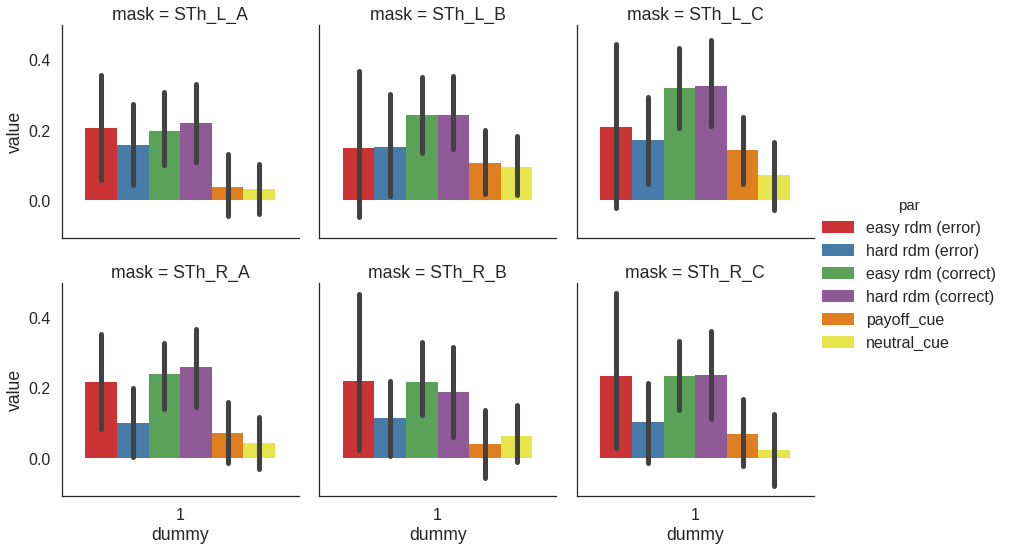

In [270]:
df_glm = pandas.DataFrame(level2_dict)
df_glm = df_glm.query('par != "constant"')
df_glm['dummy'] = 1

df_glm['% signal change'] = df_glm['value']
sns.set_palette('Set1')
sns.set_context('poster')
sns.set_style('white')

# sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95, hue_order=['payoff_cue (left)', 'payoff_cue (right)', 'neutral_cue','difficult_rdm', 'easy_rdm'])
sns.factorplot(x='dummy', y='value', hue='par', data=df_glm, col='mask', col_wrap=3, kind='bar', ci=95)

df_glm_no_errors = df_glm.copy()

In [271]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')
tmp = df_glm.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])

tmp = tmp['hard rdm (correct)'] - tmp['easy rdm (correct)']
shifts = shifts.merge(tmp, left_index=True, right_index=True)

In [272]:
from statsmodels.sandbox.stats import multicomp

In [273]:
import statsmodels

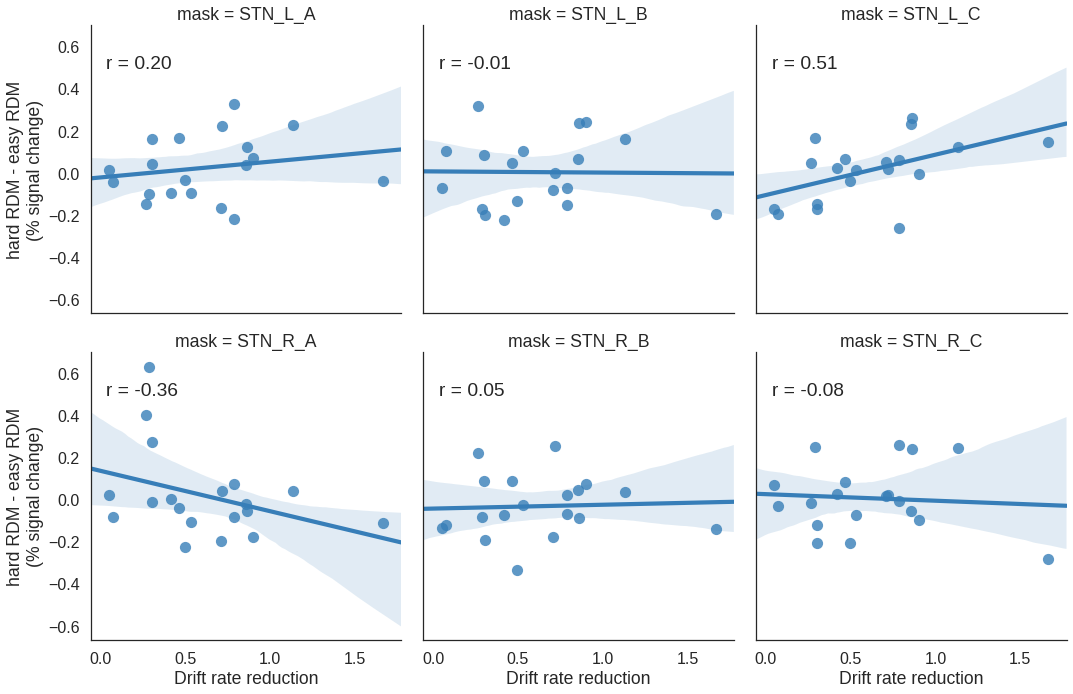

In [274]:
tmp = pandas.melt(shifts, id_vars=['v_cue_coding', 'v_difficulty', 'z_cue_coding'], var_name='mask')

tmp['mask'] = tmp['mask'].apply(lambda x: x.replace('STh', 'STN'))

# fac = sns.FacetGrid(tmp, col='mask', col_wrap=3)

# # def lmplot(x, y, color, **kwargs):
# #     sns.lmplot(x, y, **kwargs)

def make_r_title(x, y, **kwargs):
    r, p = sp.stats.pearsonr(x, y)
    
    title = plt.gca().get_title()
    
    ax = plt.gca()

    y = 0.85 - len(ax.texts) * 0.05
    ax.annotate('r = %.2f' % (r), xy=(0.05,y), xycoords='axes fraction')

tmp['v_difficulty'] *= -1

sns.set_palette(sns.color_palette('Set1')[1:])
    
fac = sns.lmplot('v_difficulty', 'value', data=tmp, col='mask', col_wrap=3)
fac.map(make_r_title, 'v_difficulty', 'value', )
# fac.set_titles('{col_name}')
fac.set_xlabels('Drift rate reduction')
fac.set_ylabels('hard RDM - easy RDM\n(% signal change)')

plt.savefig('/home/gdholla1/projects/bias/reports/figures/drift_rate_bold_interindividual.pdf')

In [275]:
results = []

for mask in masks:
    r, p = sp.stats.pearsonr(shifts['v_difficulty'], shifts[mask])
    
    results.append({'mask':mask, 'r':r, 'p':p})
    
results = pandas.DataFrame(results)
_, p_fdr, _, _ = statsmodels.sandbox.stats.multicomp.multipletests(results['p'], method='fdr_bh')
results['p.fdr'] = p_fdr
results

,mask,p,r,p.fdr
0,STh_L_A,0.419305,-0.196821,0.838610
1,STh_L_B,0.957400,0.013147,0.957400
2,STh_L_C,0.024563,-0.513400,0.147377
3,STh_R_A,0.133601,0.356914,0.400802
4,STh_R_B,0.841266,-0.049263,0.957400
5,STh_R_C,0.754720,0.076781,0.957400


In [278]:
%%R -i shifts -o chains_left
library(BayesFactor)

bf = regressionBF(v_difficulty ~ 1 + STh_L_A + STh_L_B + STh_L_C, data = shifts, whichModels='all')
print(bf)
chains_left = posterior(bf[7], iterations = 100000)
print(summary(chains_left))


bf = regressionBF(v_difficulty ~ 1 + STh_R_A + STh_R_B + STh_R_C, data = shifts, whichModels='all')
print(bf)




  |======================================================================| 100%
Bayes factor analysis
--------------
[1] STh_L_A                     : 0.513107  ±0%
[2] STh_L_B                     : NA        ±NA%
[3] STh_L_C                     : 2.756678  ±0.01%
[4] STh_L_A + STh_L_B           : 0.2735582 ±0%
[5] STh_L_A + STh_L_C           : 2.835412  ±0%
[6] STh_L_B + STh_L_C           : 1.38006   ±0%
[7] STh_L_A + STh_L_B + STh_L_C : 1.928123  ±0%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS


Iterations = 1:1e+05
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean     SD  Naive SE Time-series SE
STh_L_A -0.6826 0.4931 0.0015592       0.001804
STh_L_B  0.3569 0.4331 0.0013694       0.001460
STh_L_C -1.2205 0.5659 0.0017895       0.002435
sig2     0.1158 0.0439 0.0001388       0.000170
g        0.2731 0.5971 0

0.82640000000000002

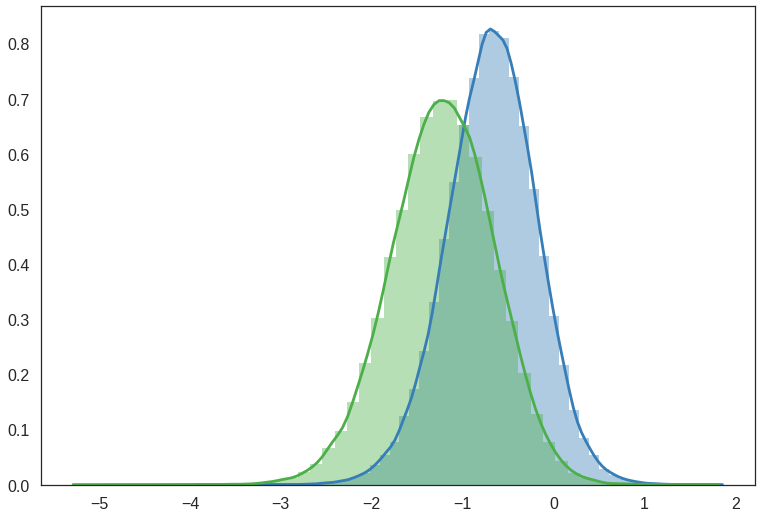

In [283]:
sns.distplot(chains_left[: ,0])
sns.distplot(chains_left[: ,2])

((chains_left[: ,0] - chains_left[: ,2]) > 0).mean()

0.0

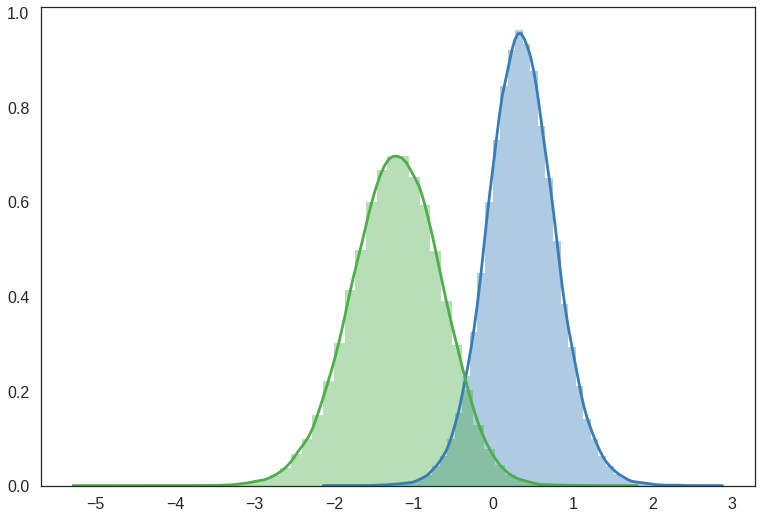

In [284]:
sns.distplot(chains_left[: ,1])
sns.distplot(chains_left[: ,2])

((chains_left[: ,1] - chains_left[: ,1]) > 0).mean()

In [232]:
shifts = pandas.read_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')
shifts = shifts.set_index('subj_idx')

tmp = df_glm_include_errors.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])
tmp = tmp['difficult_rdm'] - tmp['easy_rdm']
include_errors = shifts.merge(tmp, left_index=True, right_index=True)
include_errors = pandas.melt(include_errors, id_vars=['v_cue_coding', 'v_difficulty', 'z_cue_coding'], var_name='mask')
include_errors['errors'] = 'Includes errors'


tmp = df_glm_no_errors.pivot_table(index='subject_id', values='value', columns=['par', 'mask'])
tmp = tmp['hard rdm (correct)'] - tmp['easy rdm (correct)']
no_errors = shifts.merge(tmp, left_index=True, right_index=True)
no_errors = pandas.melt(no_errors, id_vars=['v_cue_coding', 'v_difficulty', 'z_cue_coding'], var_name='mask')
no_errors['errors'] = 'Only correct trials'

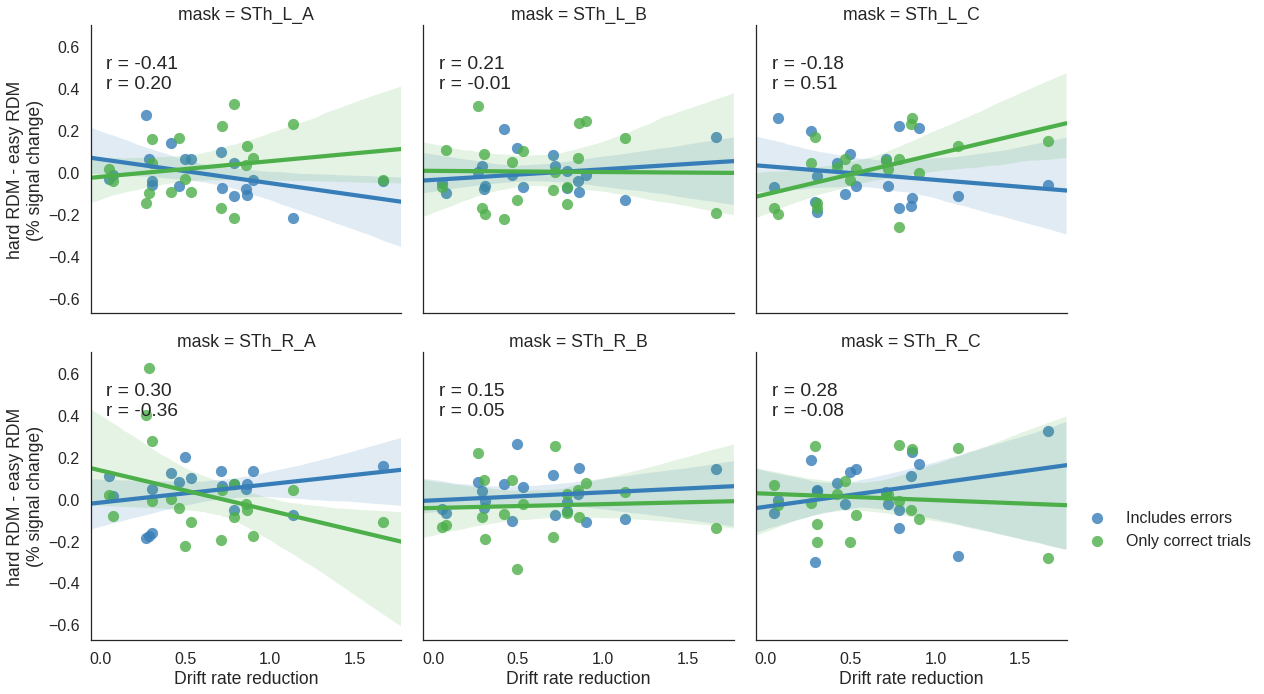

In [233]:
def make_r_title(x, y, **kwargs):
    r, p = sp.stats.pearsonr(x, y)
    
    title = plt.gca().get_title()
    
    ax = plt.gca()

    y = 0.85 - len(ax.texts) * 0.07
    ax.annotate('r = %.2f' % (r), xy=(0.05,y), xycoords='axes fraction')


sns.set_palette(sns.color_palette('Set1')[1:])
    
tmp = pandas.concat([include_errors, no_errors])    

tmp['v_difficulty'] *= -1
    
fac = sns.lmplot('v_difficulty', 'value', hue='errors', data=tmp, col='mask', col_wrap=3, legend_out=False)
fac.map(make_r_title, 'v_difficulty', 'value', )
# fac.set_titles('{col_name}')
fac.set_xlabels('Drift rate reduction')
fac.set_ylabels('hard RDM - easy RDM\n(% signal change)')
sns.plt.legend(loc='upper left',bbox_to_anchor=(1,0.5))